# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

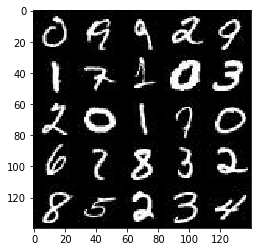

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

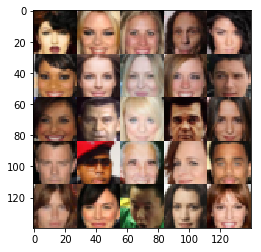

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units=128
    #ADDED BY REVIEW
    alpha = 0.10
    dropout_rate = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        print("images.get_shape()",images.get_shape())
        
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #Added By Review
        x1 = tf.layers.dropout(inputs=x1, rate=dropout_rate,training=True)
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        
        bn2 = tf.layers.dropout(inputs=bn2, rate=dropout_rate, training=True)
        
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x64
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        
        bn3 = tf.layers.dropout(inputs=bn3, rate=dropout_rate, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x128
        
        x4 = tf.layers.conv2d(relu3, 256, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn4 = tf.layers.batch_normalization(x4, training=True)
        
        bn4 = tf.layers.dropout(inputs=bn4, rate=dropout_rate, training=True)
        
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu4, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits 
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

images.get_shape() (?, 28, 28, 3)
images.get_shape() (?, 28, 28, 3)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    n_units=128
    alpha = 0.10
    #dropout_rate = 0.2    
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training= is_train)
        #ADDED BY REVIEW
        #x1 = tf.layers.dropout(inputs=x1, rate=dropout_rate, training= is_train)
        
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        #SUGGESTED 256= 2x128
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        #ADDED BY REVIEW
        #x2 = tf.layers.dropout(inputs=x2, rate=dropout_rate, training= is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        #SUGGESTED 128= 2x64
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training= is_train)
        #ADDED BY REVIEW
        #x3 = tf.layers.dropout(inputs=x3, rate=dropout_rate, training= is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        #SUGGESTED 128= 2x64
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x4 = tf.layers.batch_normalization(x4, training= is_train)
        #ADDED BY REVIEW
        #x4 = tf.layers.dropout(inputs=x4, rate=dropout_rate, training= is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x32 now
        
        # Output layer
        print("out_channel_dim",out_channel_dim)
        #ADDED BY REVIEW
        #x3 = tf.layers.dropout(inputs=x1, rate=dropout_rate, training= is_train)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim,3, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #ADDED BY REVIEW
        #logits = tf.layers.batch_normalization(logits, training= is_train)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

out_channel_dim 5
out_channel_dim 5
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #alpha = 0.01
    # ADDED BY REVIEW Smoothing 
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
   
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(tf.ones_like(d_model_real)*(1 - smooth))))
  
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
   
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

out_channel_dim 4
images.get_shape() (?, 28, 28, 4)
images.get_shape() (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    print ("data_shape ",data_shape)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    print_every=10
    show_every=100
    samples, losses = [], []
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # ?????
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z})
                #ADDED BY REVIEW: 2 times generator optimization
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format( epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                #if steps % show_every == 0:
                #    gen_samples = sess.run(
                       
                #                   generator(input_z, data_shape[3], is_train=False),
                #                   feed_dict={input_z: sample_z})
                #    samples.append(gen_samples)
                #    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                #    plt.show()
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')

   
    
             

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

mnist_dataset.shape:  (60000, 28, 28, 1)
data_shape  (60000, 28, 28, 1)
out_channel_dim 1
images.get_shape() (?, 28, 28, 1)
images.get_shape() (?, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.4700... Generator Loss: 3.5762
Epoch 1/2... Discriminator Loss: 0.4120... Generator Loss: 6.0782
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 13.6175
Epoch 1/2... Discriminator Loss: 0.3965... Generator Loss: 7.3371
Epoch 1/2... Discriminator Loss: 0.3969... Generator Loss: 5.3513
Epoch 1/2... Discriminator Loss: 1.8258... Generator Loss: 3.8499
Epoch 1/2... Discriminator Loss: 1.3326... Generator Loss: 1.2836
Epoch 1/2... Discriminator Loss: 1.9338... Generator Loss: 2.7529
Epoch 1/2... Discriminator Loss: 1.5131... Generator Loss: 1.7296
Epoch 1/2... Discriminator Loss: 1.7816... Generator Loss: 2.5040
out_channel_dim 1


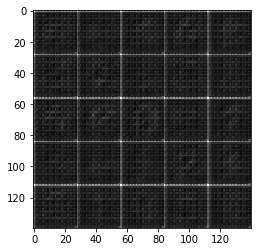

Epoch 1/2... Discriminator Loss: 1.4879... Generator Loss: 1.3384
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 1.2672
Epoch 1/2... Discriminator Loss: 1.6022... Generator Loss: 0.4991
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.9670
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 1.0599
Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 1.2844
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 1.5924... Generator Loss: 0.5252
Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 1.5222
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 1.0814
out_channel_dim 1


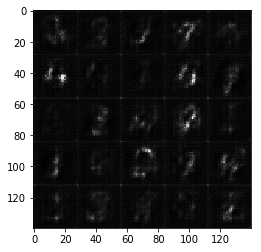

Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 1.4130
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 1.3125
Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 1.3599
Epoch 1/2... Discriminator Loss: 1.6236... Generator Loss: 2.0432
Epoch 1/2... Discriminator Loss: 1.5455... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 1.1112
Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 1.2793
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 1.4455
Epoch 1/2... Discriminator Loss: 1.4983... Generator Loss: 1.6656
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 1.2885
out_channel_dim 1


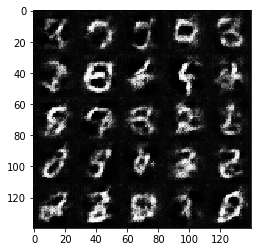

Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 1.3024
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 1.4536
Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 1.4070
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.8982
Epoch 1/2... Discriminator Loss: 1.3297... Generator Loss: 1.3302
Epoch 1/2... Discriminator Loss: 1.2225... Generator Loss: 1.0776
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 1.2614
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 1.0620
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.6908
Epoch 1/2... Discriminator Loss: 1.6846... Generator Loss: 0.3833
out_channel_dim 1


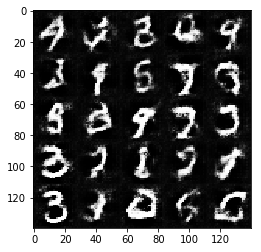

Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 1.3297
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 1.9183
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 1.2410
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 1.3003
Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 1.0197
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 1.5827
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 1.0063
out_channel_dim 1


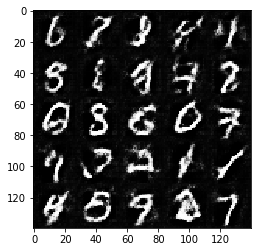

Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 1.7070
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 1.1847
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.5960
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.7047
Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 1.3165... Generator Loss: 1.5012
Epoch 2/2... Discriminator Loss: 1.3552... Generator Loss: 1.2546
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 1.6183
out_channel_dim 1


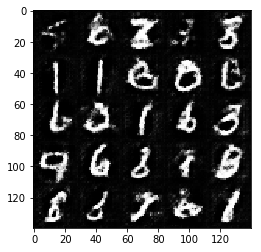

Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 1.0309
Epoch 2/2... Discriminator Loss: 1.2384... Generator Loss: 0.8296
Epoch 2/2... Discriminator Loss: 1.5990... Generator Loss: 1.8775
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.7628
Epoch 2/2... Discriminator Loss: 1.2658... Generator Loss: 0.7745
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.9275
Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 1.1203
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.6210
Epoch 2/2... Discriminator Loss: 1.5778... Generator Loss: 0.5127
Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 1.3061
out_channel_dim 1


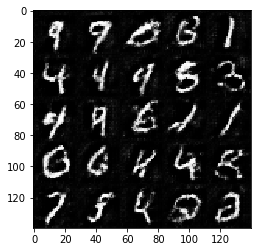

Epoch 2/2... Discriminator Loss: 1.3057... Generator Loss: 1.2763
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.9570
Epoch 2/2... Discriminator Loss: 1.6560... Generator Loss: 1.9712
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 1.1086
Epoch 2/2... Discriminator Loss: 1.3986... Generator Loss: 0.5984
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.9201
Epoch 2/2... Discriminator Loss: 1.4188... Generator Loss: 0.6302
Epoch 2/2... Discriminator Loss: 1.5528... Generator Loss: 0.4745
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.9418
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.8310
out_channel_dim 1


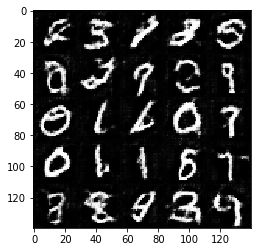

Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 1.2067
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 1.4921
Epoch 2/2... Discriminator Loss: 1.4629... Generator Loss: 0.5892
Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 0.7475
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.7019
Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 1.4660... Generator Loss: 1.5366
Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 1.1681
Epoch 2/2... Discriminator Loss: 1.3357... Generator Loss: 1.2328
Epoch 2/2... Discriminator Loss: 1.2372... Generator Loss: 1.2729
out_channel_dim 1


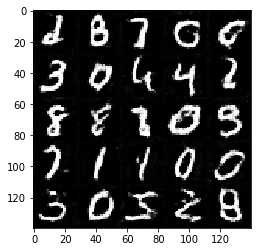

Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.9673
Epoch 2/2... Discriminator Loss: 1.4773... Generator Loss: 0.5722
Epoch 2/2... Discriminator Loss: 1.5653... Generator Loss: 0.4799


In [12]:
#ADDED BY REVIEW (doubled)
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("mnist_dataset.shape: ", mnist_dataset.shape)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape  (202599, 28, 28, 3)
out_channel_dim 3
images.get_shape() (?, 28, 28, 3)
images.get_shape() (?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 3.1877
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 3.4332
Epoch 1/1... Discriminator Loss: 4.3565... Generator Loss: 0.0691
Epoch 1/1... Discriminator Loss: 1.8248... Generator Loss: 2.2798
Epoch 1/1... Discriminator Loss: 2.3301... Generator Loss: 0.3215
Epoch 1/1... Discriminator Loss: 2.3795... Generator Loss: 0.2578
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 1.8826
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.9239... Generator Loss: 1.8811
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.9515
out_channel_dim 3


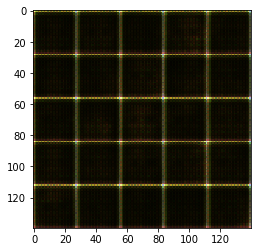

Epoch 1/1... Discriminator Loss: 1.8195... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.9560... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.9631... Generator Loss: 0.2711
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 2.1857... Generator Loss: 0.2685
Epoch 1/1... Discriminator Loss: 2.3579... Generator Loss: 0.2303
Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.9586... Generator Loss: 0.4273
out_channel_dim 3


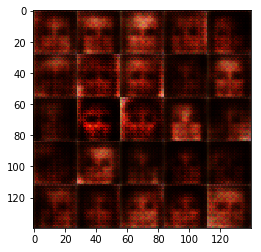

Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.6463... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 1.7385... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 1.0592
Epoch 1/1... Discriminator Loss: 1.8007... Generator Loss: 1.9149
Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.9189
out_channel_dim 3


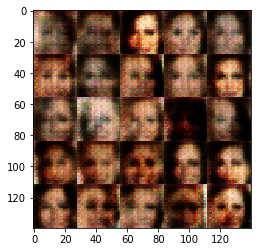

Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.7763... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.4181
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.9382
out_channel_dim 3


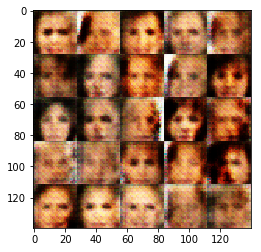

Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 2.2130... Generator Loss: 0.1787
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 3.0725
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.8834
out_channel_dim 3


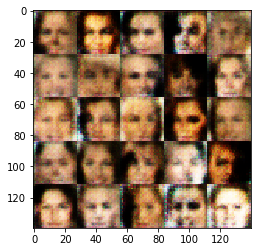

Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.4688
Epoch 1/1... Discriminator Loss: 1.6897... Generator Loss: 2.9528
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 1.5118
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.1823
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.2962
out_channel_dim 3


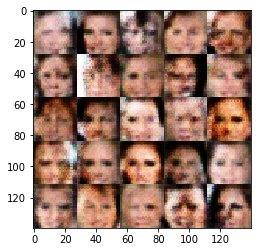

Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.5588
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.3779
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.8406... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.9228
out_channel_dim 3


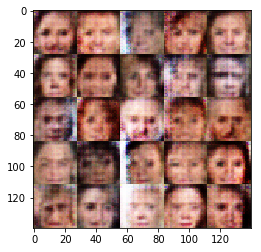

Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 1.5034
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7754
out_channel_dim 3


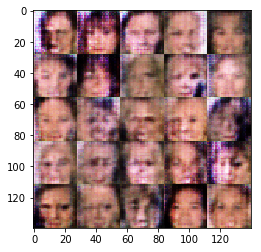

Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 1.7076... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8078
out_channel_dim 3


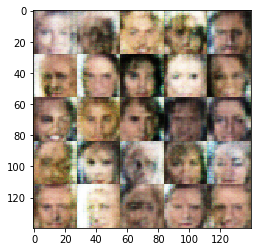

Epoch 1/1... Discriminator Loss: 1.5846... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.6293
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 1.6401
out_channel_dim 3


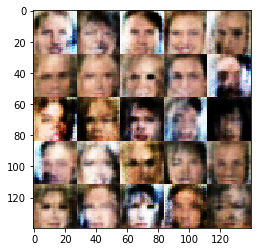

Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 1.3064
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.7455... Generator Loss: 1.8942
out_channel_dim 3


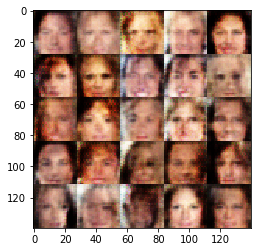

Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.9426... Generator Loss: 0.3982
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.6359... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 1.6001... Generator Loss: 0.4154
out_channel_dim 3


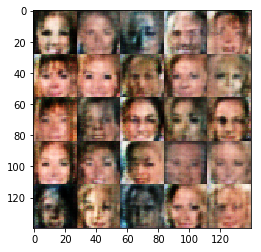

Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 1.0666
out_channel_dim 3


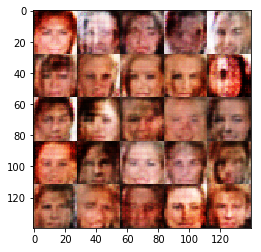

Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.4229
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.7655
out_channel_dim 3


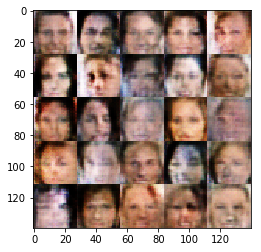

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 1.0393
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.7061
out_channel_dim 3


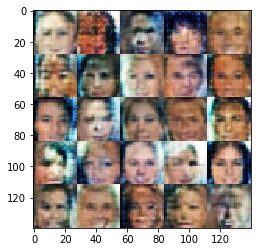

Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 1.7128... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.9912
out_channel_dim 3


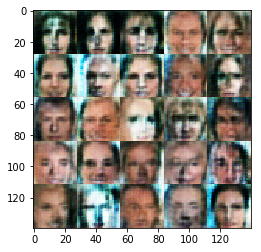

Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.9909
out_channel_dim 3


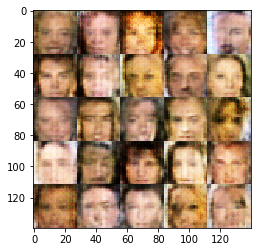

Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 1.0575
out_channel_dim 3


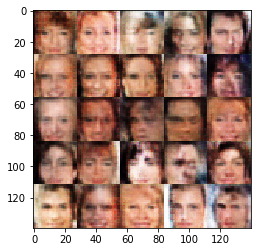

Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.3757
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.9082
out_channel_dim 3


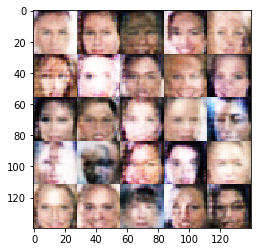

Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 1.6285... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.8804
out_channel_dim 3


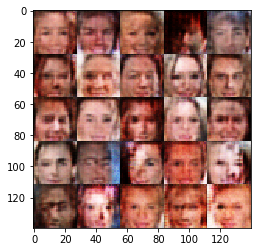

Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.9688
out_channel_dim 3


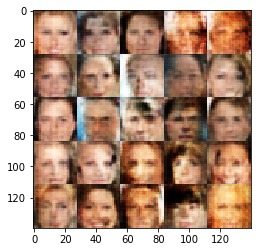

Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.7420
out_channel_dim 3


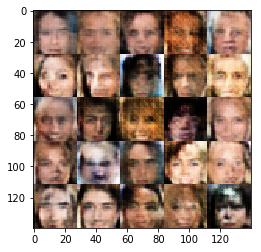

Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 1.2125
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.9754
out_channel_dim 3


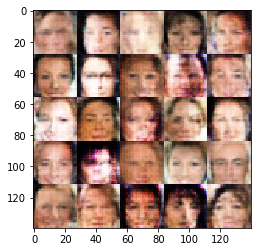

Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.6282... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 1.6152
Epoch 1/1... Discriminator Loss: 1.6469... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7502
out_channel_dim 3


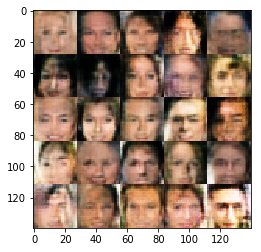

Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 1.2295
out_channel_dim 3


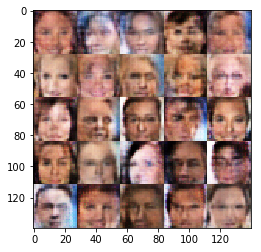

Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 1.3507
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6590
out_channel_dim 3


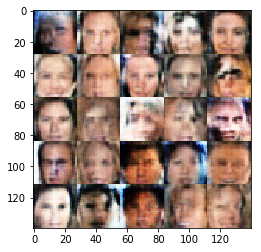

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 1.0305
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.8577
out_channel_dim 3


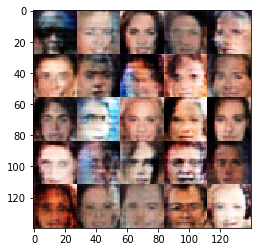

Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.9430
out_channel_dim 3


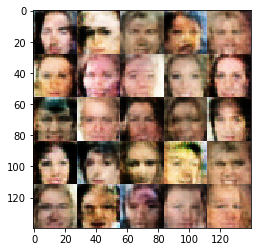

Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.0521
out_channel_dim 3


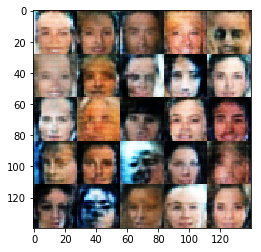

Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.9082
out_channel_dim 3


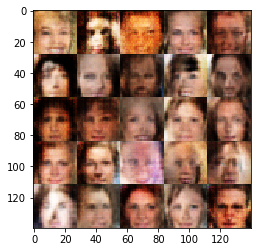

Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.7377
out_channel_dim 3


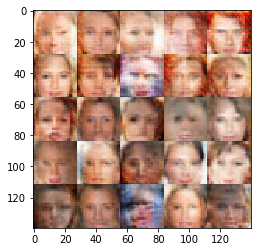

Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.6939
out_channel_dim 3


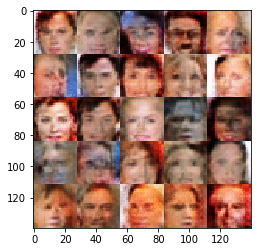

Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6804
out_channel_dim 3


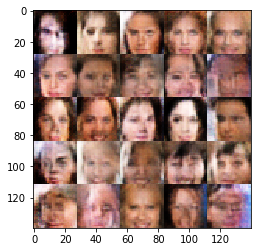

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.6877
out_channel_dim 3


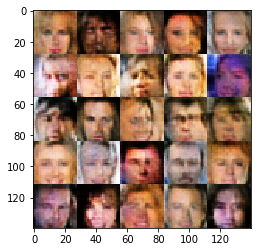

Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6213
out_channel_dim 3


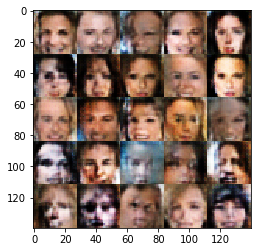

Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 1.1128
out_channel_dim 3


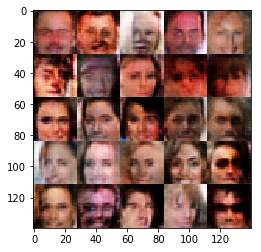

Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6461
out_channel_dim 3


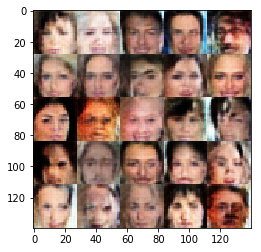

Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.9859
out_channel_dim 3


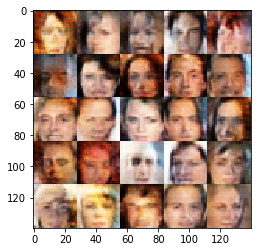

Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.7388
out_channel_dim 3


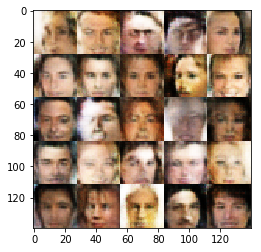

Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8205
out_channel_dim 3


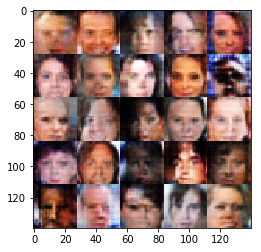

Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 1.9705
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7897
out_channel_dim 3


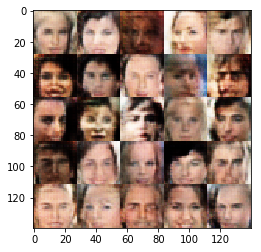

Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 1.2118
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8775
out_channel_dim 3


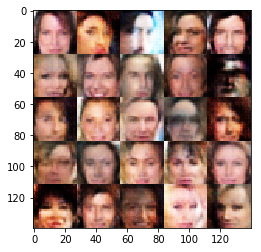

Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6949
out_channel_dim 3


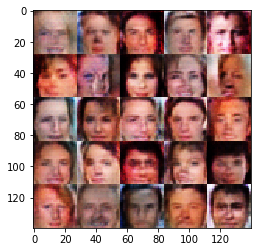

Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.9227
out_channel_dim 3


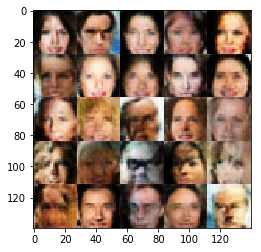

Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.8893
out_channel_dim 3


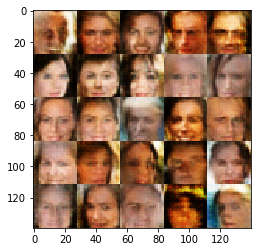

Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.5142
out_channel_dim 3


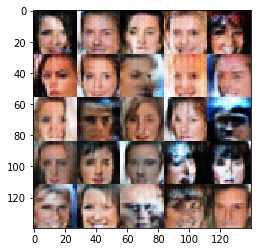

Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.9751
out_channel_dim 3


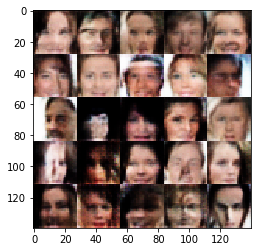

Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8323
out_channel_dim 3


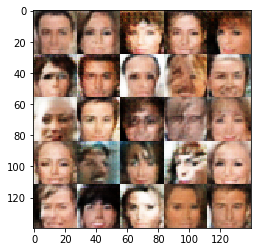

Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7938
out_channel_dim 3


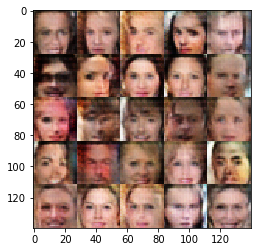

Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.9720
out_channel_dim 3


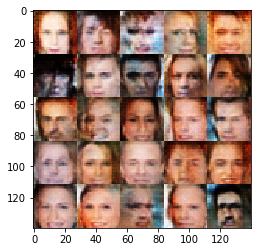

Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.6987
out_channel_dim 3


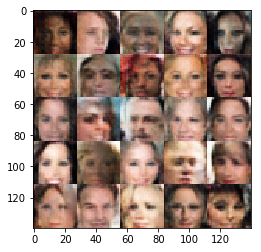

Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7599
out_channel_dim 3


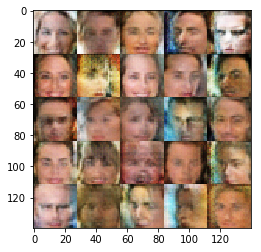

Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.7535
out_channel_dim 3


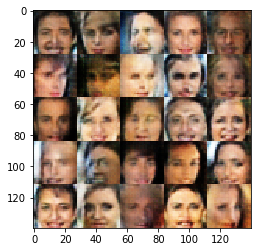

Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8804
out_channel_dim 3


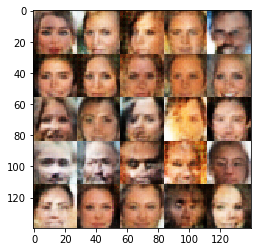

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8070
out_channel_dim 3


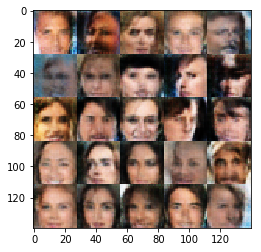

Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.7242
out_channel_dim 3


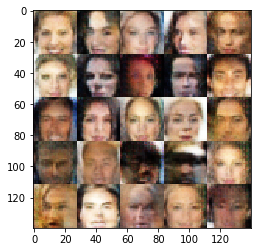

Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 1.0158
out_channel_dim 3


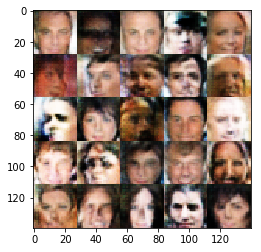

Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.7433
out_channel_dim 3


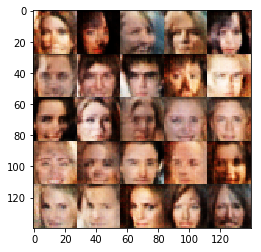

Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8885
out_channel_dim 3


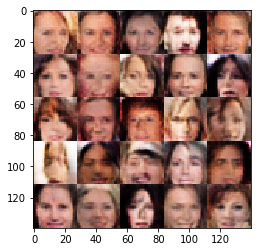

Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.8012
out_channel_dim 3


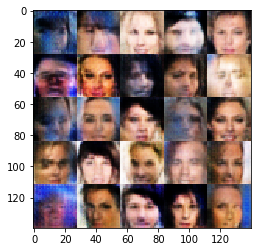

Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.8385
out_channel_dim 3


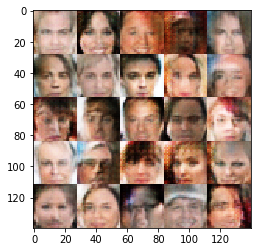

Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.7253
out_channel_dim 3


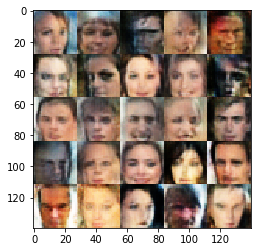

Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.7545... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.8643
out_channel_dim 3


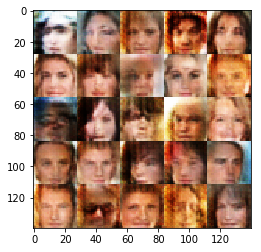

Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.9525... Generator Loss: 0.4588


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.